Making apec models for gj676a and l-980-5 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from astropy.modeling import models, fitting



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
apath = '/media/david/1tb_storage1/emergency_data/mega_muscles/apec_odds/'

In [6]:
mods = glob.glob('{}*txt*'.format(apath))
mods

["/media/david/1tb_storage1/emergency_data/mega_muscles/apec_odds/'gj676a_unnormed_mm_scale.txt'"]

In [11]:
def apec_to_spec(path):
    """
    Converts an xspec plot model wdata textfile from counts to ergs. 
    Assumes that the wavelength array is in Angstrom and the flux arrays are in counts/s/cm2/A
    """
    xrt = np.loadtxt(path, skiprows=3)
    xrt = xrt[::-1]
    wx = xrt[:,0]*u.AA
    kevx = xrt[:, 1]*u.keV
    fx  = (xrt[:,2] * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
    return wx, kevx, fx

In [12]:
wx, kevx, fx = apec_to_spec(mods[0])

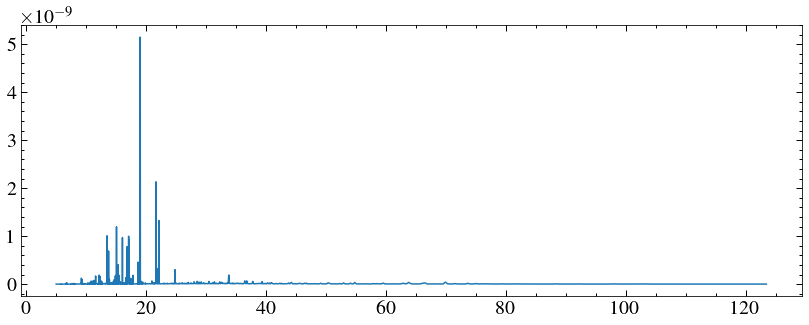

In [13]:
plt.plot(wx, fx)

In [14]:
norm = 1.04e-4 #calcuated by trial and error so that the 0.3-10keV energy matches the Swift measurement

In [15]:
#check with the SED, make sure it makes sense
sed = fits.getdata('/media/david/1tb_storage1/emergency_data/mega_muscles/v02_seds/hlsp_muscles_multi_multi_gj676a_broadband_v2_adapt-var-res-sed.fits', 1)

In [16]:
w, f = sed['WAVELENGTH'], sed['FLUX']

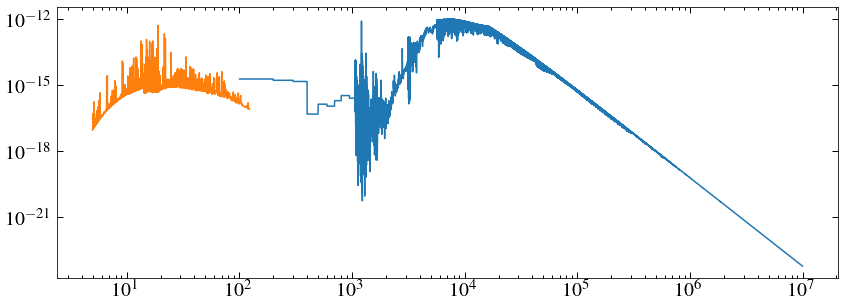

In [18]:
plt.plot(w, f)
plt.xscale('log')
plt.yscale('log')
plt.plot(wx, fx*norm)

In [19]:
check= Table.read('1GJ1132apec.txt', format='ascii.basic')

In [20]:
wc, fc = check['WAVELENGTH'], check['FLUX']

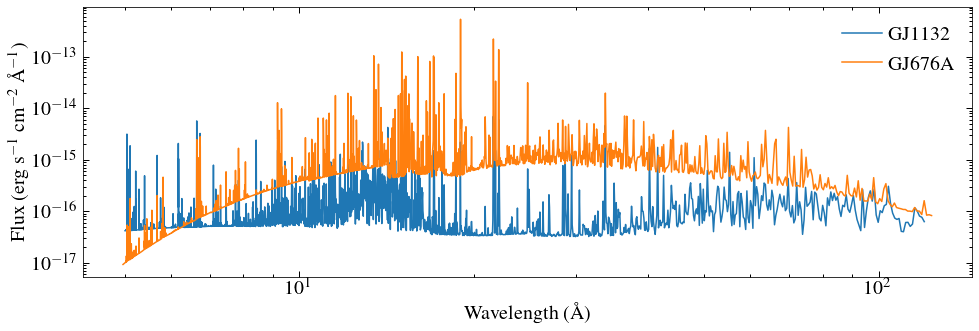

In [28]:
plt.plot(wc, fc, label ='GJ1132')
plt.yscale('log')
plt.xscale('log')
plt.plot(wx, fx*norm, label = 'GJ676A')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.savefig('plots/apec_test.pdf')

In [25]:
#why is the model curvy?